In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
import tensorflow as tf
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import math
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense

In [3]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
  X = []
  y = []
  start = start + window
  if end is None:
    end = len(dataset) - horizon
  for i in range(start, end):
    indices = range(i-window, i)
    X.append(dataset[indices])
    indicey = range(i+1, i+1+horizon)
    y.append(target[indicey])
  return np.array(X), np.array(y) 

In [9]:
df0 = pd.read_csv('smart_farm_train_nonull.csv')
df = df0.set_index('시간')
df = df.iloc[:,7:]
df.head()

,외기온(℃),외기습도(%),풍속(m/s),풍향(º),내부 온도,내부 습도,차광스크린(수평),차열스크린(수평),에너지스크린(수평),에너지스크린(수직),배기팬,천창,유동팬,팬코일 B동,환기온도(천창 제어온도),난방온도(설정온도),열공급량(kWh)
시간,,,,,,,,,,,,,,,,,
2021-11-26 00:00:00,5.8,67,0.0,325,18.3,62.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,18.0,0.9
2021-11-26 00:01:00,5.8,67,0.4,344,18.1,63.4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,18.0,0.9
2021-11-26 00:02:00,5.7,67,0.9,105,17.7,65.2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.9
2021-11-26 00:03:00,5.7,67,1.3,123,17.7,63.9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.8
2021-11-26 00:04:00,5.7,67,0.9,123,17.6,64.7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,1.0


In [10]:
print('train: ',df0[df0['년월일'] <= '2021-12-21'].shape)
print('test: ',df0[df0['년월일'] < '2021-12-25'].shape)

train:  (35630, 25)
test:  (37070, 25)


In [11]:
df.iloc[:37070,:].tail()

,외기온(℃),외기습도(%),풍속(m/s),풍향(º),내부 온도,내부 습도,차광스크린(수평),차열스크린(수평),에너지스크린(수평),에너지스크린(수직),배기팬,천창,유동팬,팬코일 B동,환기온도(천창 제어온도),난방온도(설정온도),열공급량(kWh)
시간,,,,,,,,,,,,,,,,,
2021-12-21 23:55:00,1.6,78,0.4,271,17.6,75.1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.1
2021-12-21 23:56:00,1.6,77,0.9,296,17.5,76.2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.4
2021-12-21 23:57:00,1.6,77,0.4,296,17.5,75.3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.5
2021-12-21 23:58:00,1.6,77,0.4,296,17.4,76.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.1
2021-12-21 23:59:00,1.7,77,0.4,296,17.6,75.1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.5


In [12]:
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
X_data = X_scaler.fit_transform(df.iloc[:37070,:-1])
Y_data = Y_scaler.fit_transform(df.iloc[:37070,:][['열공급량(kWh)']])

In [13]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon
    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])
        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [18]:
# As we are doing multiple-step forecasting, let’s allow the model to see past 48 hours of data and forecast the 10 hrs after data
# hist_window = 48 / horizon = 10

hist_window = 60
horizon = 10
TRAIN_SPLIT = 30000
x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, hist_window, horizon) 


In [19]:
batch_size = 256
buffer_size = 150
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat()

In [20]:
lstm_model = tf.keras.models.Sequential([
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True), 
                            input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=horizon),
])
lstm_model.compile(optimizer='adam', loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
lstm_model.summary() 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 60, 400)          347200    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 60, 20)            8020      
                                                                 
 bidirectional_3 (Bidirectio  (None, 300)              205200    
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 20)                6020      
                                                                 
 dense_6 (Dense)             (None, 20)                420       
                                                                 
 dropout_1 (Dropout)         (None, 20)               

In [21]:
model_path = 'Bidirectional_LSTM_Multivariate.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]
history = lstm_model.fit(train_data,epochs=50,steps_per_epoch=100,validation_data=val_data,validation_steps=20,verbose=1,callbacks=callbacks)

Epoch 1/50
 43/100 [===========>..................] - ETA: 14s - loss: 0.0309 - rmse: 0.1757

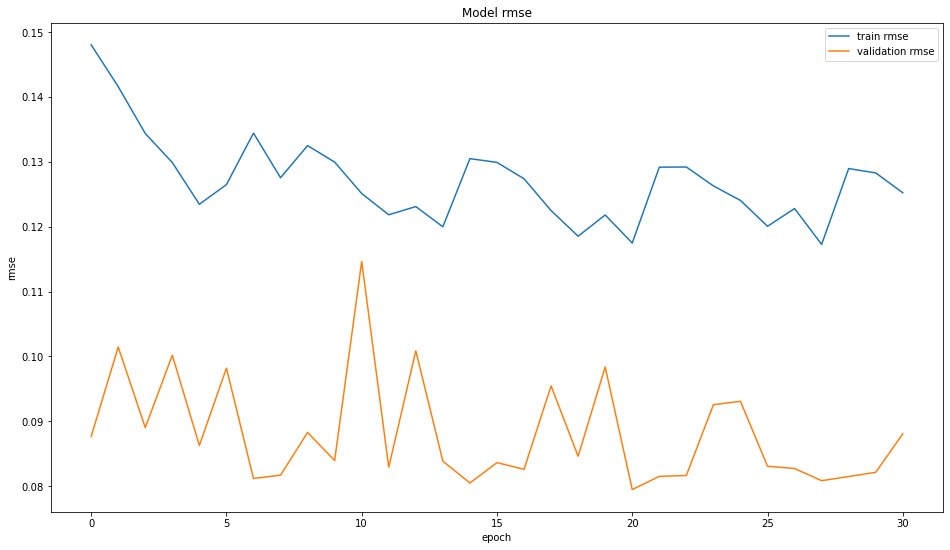

In [59]:
plt.figure(figsize=(16,9))
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('Model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train rmse', 'validation rmse'])
plt.show()